# Kaggle 2017 March Madness Tourny

In [11]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "D:\\_data_science_data\\2017_march_madness" directory.
file_path = 'D:\_data_science_data\\2017_march_madness\\'

In [16]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [14]:
reg_detailed_results = pd.read_csv(file_path+"RegularSeasonDetailedResults.csv")
reg_detailed_results[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
5,2003,11,1458,81,1186,55,H,0,26,57,...,11,12,17,6,22,8,19,4,3,25


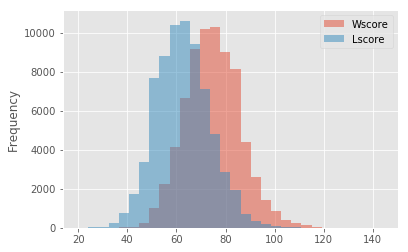

In [17]:
reg_detailed_results[['Wscore','Lscore']].plot.hist(alpha = 0.5, bins =30, stacked = False)

In [21]:
seeds = pd.read_csv(file_path+"TourneySeeds.csv")
seeds[:6]

,Season,Seed,Team
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
5,1985,W06,1208


In [22]:
def split_seed(Seed):
    return (str(Seed[0]),int(Seed[1:3]))
#print(type(split_seed('z16a')))

def get_seed_num(Seed):
    return split_seed(Seed)[1]
def get_seed_reg(Seed):
    return split_seed(Seed)[0]
#print(set(seeds['Seed']))
seeds['region'] = seeds['Seed'].apply(get_seed_reg)
seeds['num_seed'] = seeds['Seed'].apply(get_seed_num)
seeds.drop(labels=['Seed'], inplace=True, axis=1)
print(seeds[:6])

win_seeds = seeds.rename(columns={'Team':'Wteam', 'num_seed':'win_seed','region':'win_region'})
loss_seeds = seeds.rename(columns={'Team':'Lteam', 'num_seed':'loss_seed','region':'loss_region'})

print(win_seeds[:3])
print(loss_seeds[:3])

   Season  Team region  num_seed
0    1985  1207      W         1
1    1985  1210      W         2
2    1985  1228      W         3
3    1985  1260      W         4
4    1985  1374      W         5
5    1985  1208      W         6
   Season  Wteam win_region  win_seed
0    1985   1207          W         1
1    1985   1210          W         2
2    1985   1228          W         3
   Season  Lteam loss_region  loss_seed
0    1985   1207           W          1
1    1985   1210           W          2
2    1985   1228           W          3


In [23]:
tourn_compact = pd.read_csv(file_path+"TourneyCompactResults.csv")
tourn_compact[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
5,1985,136,1246,66,1449,58,N,0


In [24]:
tourn_full = pd.read_csv(file_path+"TourneyDetailedResults.csv")
tourn_full[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
5,2003,136,1163,58,1140,53,N,0,17,52,...,17,11,13,15,26,11,11,8,4,22


# Other Guy's Logistic Regression Example

In [25]:
temp = pd.merge(left=tourn_compact, right=win_seeds, how='left', on=['Season', 'Wteam'])
full_data = pd.merge(left=temp, right=loss_seeds, on=['Season', 'Lteam'])
full_data['seed_diff'] = full_data['win_seed'] - full_data['loss_seed'] 
full_data[:6]

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,win_region,win_seed,loss_region,loss_seed,seed_diff
0,1985,136,1116,63,1234,54,N,0,X,9,X,8,1
1,1985,136,1120,59,1345,58,N,0,Z,11,Z,6,5
2,1985,136,1207,68,1250,43,N,0,W,1,W,16,-15
3,1985,136,1229,58,1425,55,N,0,Y,9,Y,8,1
4,1985,136,1242,49,1325,38,N,0,Z,3,Z,14,-11
5,1985,136,1246,66,1449,58,N,0,X,12,X,5,7


In [26]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = full_data['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -full_data['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))
df_for_predictions[:6]
#len(df_for_predictions)

,seed_diff,result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1
5,7,1


In [27]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(df_for_predictions.seed_diff.values.reshape(-1,1), df_for_predictions.result.values)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5536, with best C: 0.2782559402207126


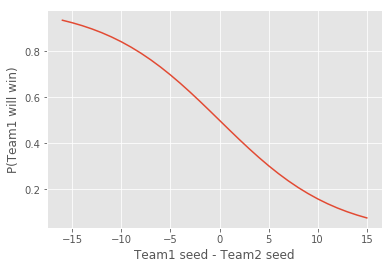

In [28]:
X = np.arange(-16, 16).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')